# Chapter 18: The Magic of Written Reports

For additional context see chapter 18 of [The Virus of Variation](https://www.brokenquality.com/book). Questions? Email James.Lehner@gmail.com or QualityIsBroken@gmail.com.

In [136]:
# Import libraries
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import seaborn as sns
import pandas as pd

%matplotlib inline

## Create process statistics helper function

In [56]:
def calc_process_stats(df, value_col, mr_col, round_value=2,
                        E2=2.660, D4=3.268, print_results=False):
    """
    Calculate process limits and return them as a dictionary.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the data.
    value_col : str
        Column name for the individual values (e.g., 'Rate').
    mr_col : str
        Column name for the moving ranges (e.g., 'Moving Range').
    round_value : int
        Number of decimal places to round to.
    E2 : float
        Constant for calculating X chart limits.
    D4 : float
        Constant for calculating mR chart limits.
    print_results : str
        Print results for calculated statistics.

    Returns
    -------
    dict
        Dictionary with mean, average moving range, and process limits.
    """

    ave_mR = round(df[mr_col].mean(), round_value)
    mean = round(df[value_col].mean(), round_value)

    UPL = round(mean + (E2 * ave_mR), round_value)
    calc_LPL = round(mean - (E2 * ave_mR), round_value)
    LPL = max(0, calc_LPL)  # ensure LPL is not negative
    URL = round(D4 * ave_mR, round_value)
    
    results = {
        "Mean": mean,
        "Average mR": ave_mR,
        "UPL": UPL,
        "Calculated LPL": calc_LPL,
        "LPL": LPL,
        "URL": URL
    }
    
    if print_results == True:
        # Print results
        print("Process Statistics:")
        for key, value in results.items():
            print(f"  {key}: {value}")

    return results

## Get the data

In [37]:
# Get data function
def get_data(dataset_url) -> pd.DataFrame:
    return pd.read_csv(dataset_url)

In [38]:
# Death-to-birth rate dataset url
rate_url = r'https://raw.githubusercontent.com/jimlehner/the-virus-of-variation/refs/heads/main/data/death-to-birth-rates-by-hospital-1784-to-1849.csv'

# Get data
rate_df = get_data(rate_url)

# Make 'Year' column dtype string
rate_df['Year'] = rate_df['Year'].astype('string')

# Drop 'Note', 'Births', and 'Deaths' columns
rate_df = rate_df.drop(['Note', 'Births', 'Deaths'], axis=1)

# Show dataframe
rate_df.head(10)

,Hospital,Year,Rate
0,Vienna General Hospital,1784,2.1
1,Vienna General Hospital,1785,1.4
2,Vienna General Hospital,1786,0.4
3,Vienna General Hospital,1787,0.4
4,Vienna General Hospital,1788,0.4
5,Vienna General Hospital,1789,0.6
6,Vienna General Hospital,1790,0.8
7,Vienna General Hospital,1791,0.6
8,Vienna General Hospital,1792,0.9
9,Vienna General Hospital,1793,2.6


### Split dataframe according to hospital

In [39]:
# Split dataframe according to hospital
# Vienna General dataframe
vienna_df = rate_df[rate_df['Hospital'] == 'Vienna General Hospital'].copy()

# Calculate Moving Range
# vienna_df['Moving Range'] = abs(vienna_df['Rate'].diff())

# Dublin Maternity dataframe
dublin_df = rate_df[rate_df['Hospital'] == 'Dublin Maternity Hospital'].reset_index(drop=True)

# Show vienna_df
vienna_df.head(10)

,Hospital,Year,Rate
0,Vienna General Hospital,1784,2.1
1,Vienna General Hospital,1785,1.4
2,Vienna General Hospital,1786,0.4
3,Vienna General Hospital,1787,0.4
4,Vienna General Hospital,1788,0.4
5,Vienna General Hospital,1789,0.6
6,Vienna General Hospital,1790,0.8
7,Vienna General Hospital,1791,0.6
8,Vienna General Hospital,1792,0.9
9,Vienna General Hospital,1793,2.6


### Split dataframe according to before and after pathological anatomy

In [40]:
# Before pathological anatomy (1784 to 1822)
before_df = vienna_df.iloc[:39].copy()
# Calculate the moving range
before_df['Moving Range'] = abs(before_df['Rate'].diff())

# After pathological anatomy (1823 to 1840)
after_df = vienna_df.iloc[39:57].reset_index(drop=True).copy()
after_df['Moving Range'] = abs(after_df['Rate'].diff())

# Show after_df
after_df

,Hospital,Year,Rate,Moving Range
0,Vienna General Hospital,1823,7.5,NaN
1,Vienna General Hospital,1824,4.9,2.6
2,Vienna General Hospital,1825,8.8,3.9
3,Vienna General Hospital,1826,8.1,0.7
4,Vienna General Hospital,1827,2.2,5.9
5,Vienna General Hospital,1828,3.6,1.4
6,Vienna General Hospital,1829,4.6,1.0
7,Vienna General Hospital,1830,4.0,0.6
8,Vienna General Hospital,1831,6.6,2.6
9,Vienna General Hospital,1832,3.2,3.4


## Figure CS.1: XmR chart of death-to-birth rates before pathological anatomy, 1784 to 1822

In [60]:
# Calculate before pathological anatomy process statistics
before_stats = calc_process_stats(before_df, 'Rate', 'Moving Range')

# Show results
before_stats

{'Mean': 1.16,
 'Average mR': 0.85,
 'UPL': 3.42,
 'Calculated LPL': -1.1,
 'LPL': 0,
 'URL': 2.78}

In [112]:
# Specify round_value
round_value = 2
tickinterval = 3

# Prepare data for plotting
data = before_df["Rate"]
moving_range = round(abs(data.diff()),round_value)
labels = before_df["Year"]

# --- Masking parameters ---
upper_lim = np.ma.masked_where(data < before_stats['UPL'], data)
lower_lim = np.ma.masked_where(data > before_stats['LPL'], data)

url_greater = np.ma.masked_where(moving_range <= before_stats['URL'], moving_range)

# --- Line styles and colors ---
x_limits = ['Mean', 'UPL', 'LPL']
mr_limits = ['Average mR', 'URL']

# Map each limit to its linestyle/color
line_styles = {
    'Mean': ('-', 'black'),
    'Average mR': ('-', 'black'),
    'UPL': ('--', 'red'),
    'LPL': ('--', 'red'),
    'URL': ('--', 'red')
}

# --- Create lines and labels dynamically ---
xchart_lines  = [(before_stats[k], *line_styles[k]) for k in x_limits]
mrchart_lines = [(before_stats[k], *line_styles[k]) for k in mr_limits]

xchart_labels = [(before_stats[k], before_stats[k]) for k in x_limits]
mrchart_labels = [(before_stats[k], before_stats[k]) for k in mr_limits]

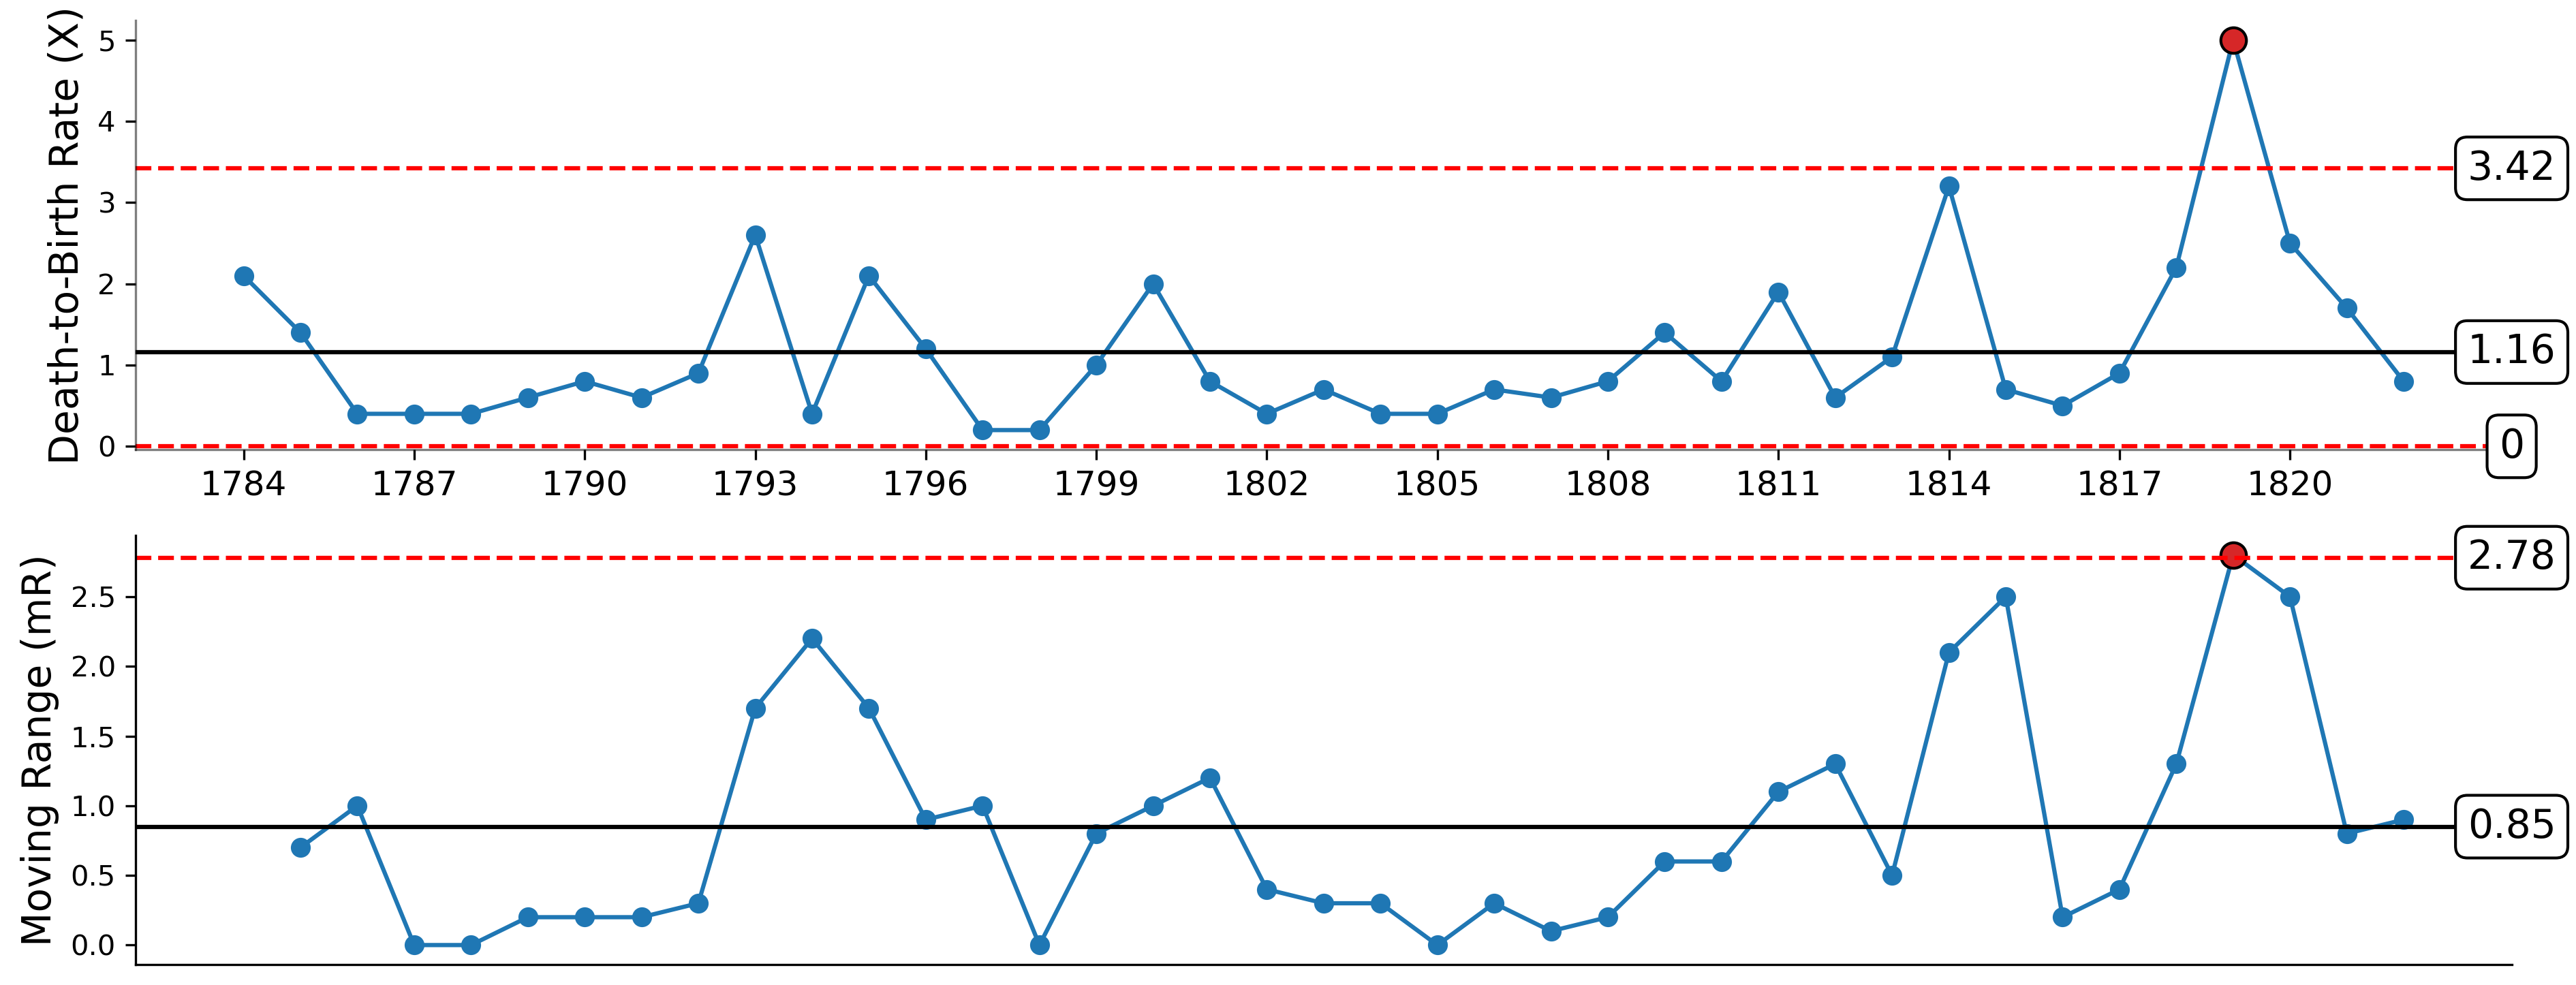

In [114]:
# --- Figure & Axes ---
fig, ax = plt.subplots(2, 1, figsize=(15, 6), dpi=300)

# --- Plot main data ---
ax[0].plot(labels, data, marker='o', label='X data')
ax[1].plot(labels, moving_range, marker='o', label='mR data')

# Create masking parameters for values beyond process limits
masked_values = {
    "upper_lim": np.ma.masked_where(data < before_stats['UPL'], data),
    "lower_lim": np.ma.masked_where(data >  before_stats['LPL'], data),
    "url_greater": np.ma.masked_where(moving_range <= before_stats['URL'], moving_range)
}

# Function to highlight points outside process limits
def highlight_assignable_causes(ax, labels, masked_values, color='tab:red', size=9):
    for key, masked_data in masked_values.items():
        ax.plot(labels, masked_data, marker='o', ls='none', color=color,
                markeredgecolor='black', markersize=size)

# Apply outlier highlighting
highlight_assignable_causes(ax[0], labels, {"upper_lim": masked_values["upper_lim"], "lower_lim": masked_values["lower_lim"]})
highlight_assignable_causes(ax[1], labels, {"url_greater": masked_values["url_greater"]})

# Offset moving ranges by plotting invisible x’s where values are NaN
for xi, yi in zip(labels, moving_range):
    if np.isnan(yi):
        ax[1].plot(xi, 0, marker='x', color='white', markersize=0)

# --- Add process limit & centerline lines ---
for value, linestyle, color in xchart_lines:
    ax[0].axhline(value, ls=linestyle, color=color)
for value, linestyle, color in mrchart_lines:
    ax[1].axhline(value, ls=linestyle, color=color)

# --- Add text labels for limits & centerlines ---
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
for y_val, label in xchart_labels:
    ax[0].text(
        ax[0].get_xlim()[1], y_val, label,
        ha='center', va='center', fontsize=14, bbox=bbox_props
    )
for y_val, label in mrchart_labels:
    ax[1].text(
        ax[1].get_xlim()[1], y_val, label,
        ha='center', va='center', fontsize=14, bbox=bbox_props
    )

# --- Aesthetics ---
sns.despine()
ax[0].spines[['left', 'bottom']].set_alpha(0.5)

# --- X-axis formatting ---
tick_interval = tickinterval
tick_positions = np.arange(0, len(labels), tick_interval)
ax[0].set_xticks(tick_positions)
ax[0].set_xticklabels(labels.iloc[tick_positions], fontsize=12)
ax[1].set_xticks([])  # remove ticks from lower chart

# --- Labels ---
ax[0].set_ylabel("Death-to-Birth Rate (X)", fontsize=14)
ax[1].set_ylabel("Moving Range (mR)", fontsize=14)

# plt.tight_layout()
plt.show()

## Figure CS.2: XmR chart of death-to-birth rates after pathological anatomy, 1823 to 1826

In [115]:
# Calculate after pathological anatomy statistics
after_stats = calc_process_stats(after_df, 'Rate', 'Moving Range')

# Show results
after_stats

{'Mean': 5.91,
 'Average mR': 2.62,
 'UPL': 12.88,
 'Calculated LPL': -1.06,
 'LPL': 0,
 'URL': 8.56}

In [122]:
# Specify round_value
round_value = 2
tickinterval = 2

# Prepare data for plotting
data = after_df["Rate"]
moving_range = round(abs(data.diff()),round_value)
labels = after_df["Year"]

# --- Masking parameters ---
upper_lim = np.ma.masked_where(data < after_stats['UPL'], data)
lower_lim = np.ma.masked_where(data > after_stats['LPL'], data)

url_greater = np.ma.masked_where(moving_range <= after_stats['URL'], moving_range)

# --- Line styles and colors ---
x_limits = ['Mean', 'UPL', 'LPL']
mr_limits = ['Average mR', 'URL']

# Map each limit to its linestyle/color
line_styles = {
    'Mean': ('-', 'black'),
    'Average mR': ('-', 'black'),
    'UPL': ('--', 'red'),
    'LPL': ('--', 'red'),
    'URL': ('--', 'red')
}

# --- Create lines and labels dynamically ---
xchart_lines  = [(after_stats[k], *line_styles[k]) for k in x_limits]
mrchart_lines = [(after_stats[k], *line_styles[k]) for k in mr_limits]

xchart_labels = [(after_stats[k], after_stats[k]) for k in x_limits]
mrchart_labels = [(after_stats[k], after_stats[k]) for k in mr_limits]

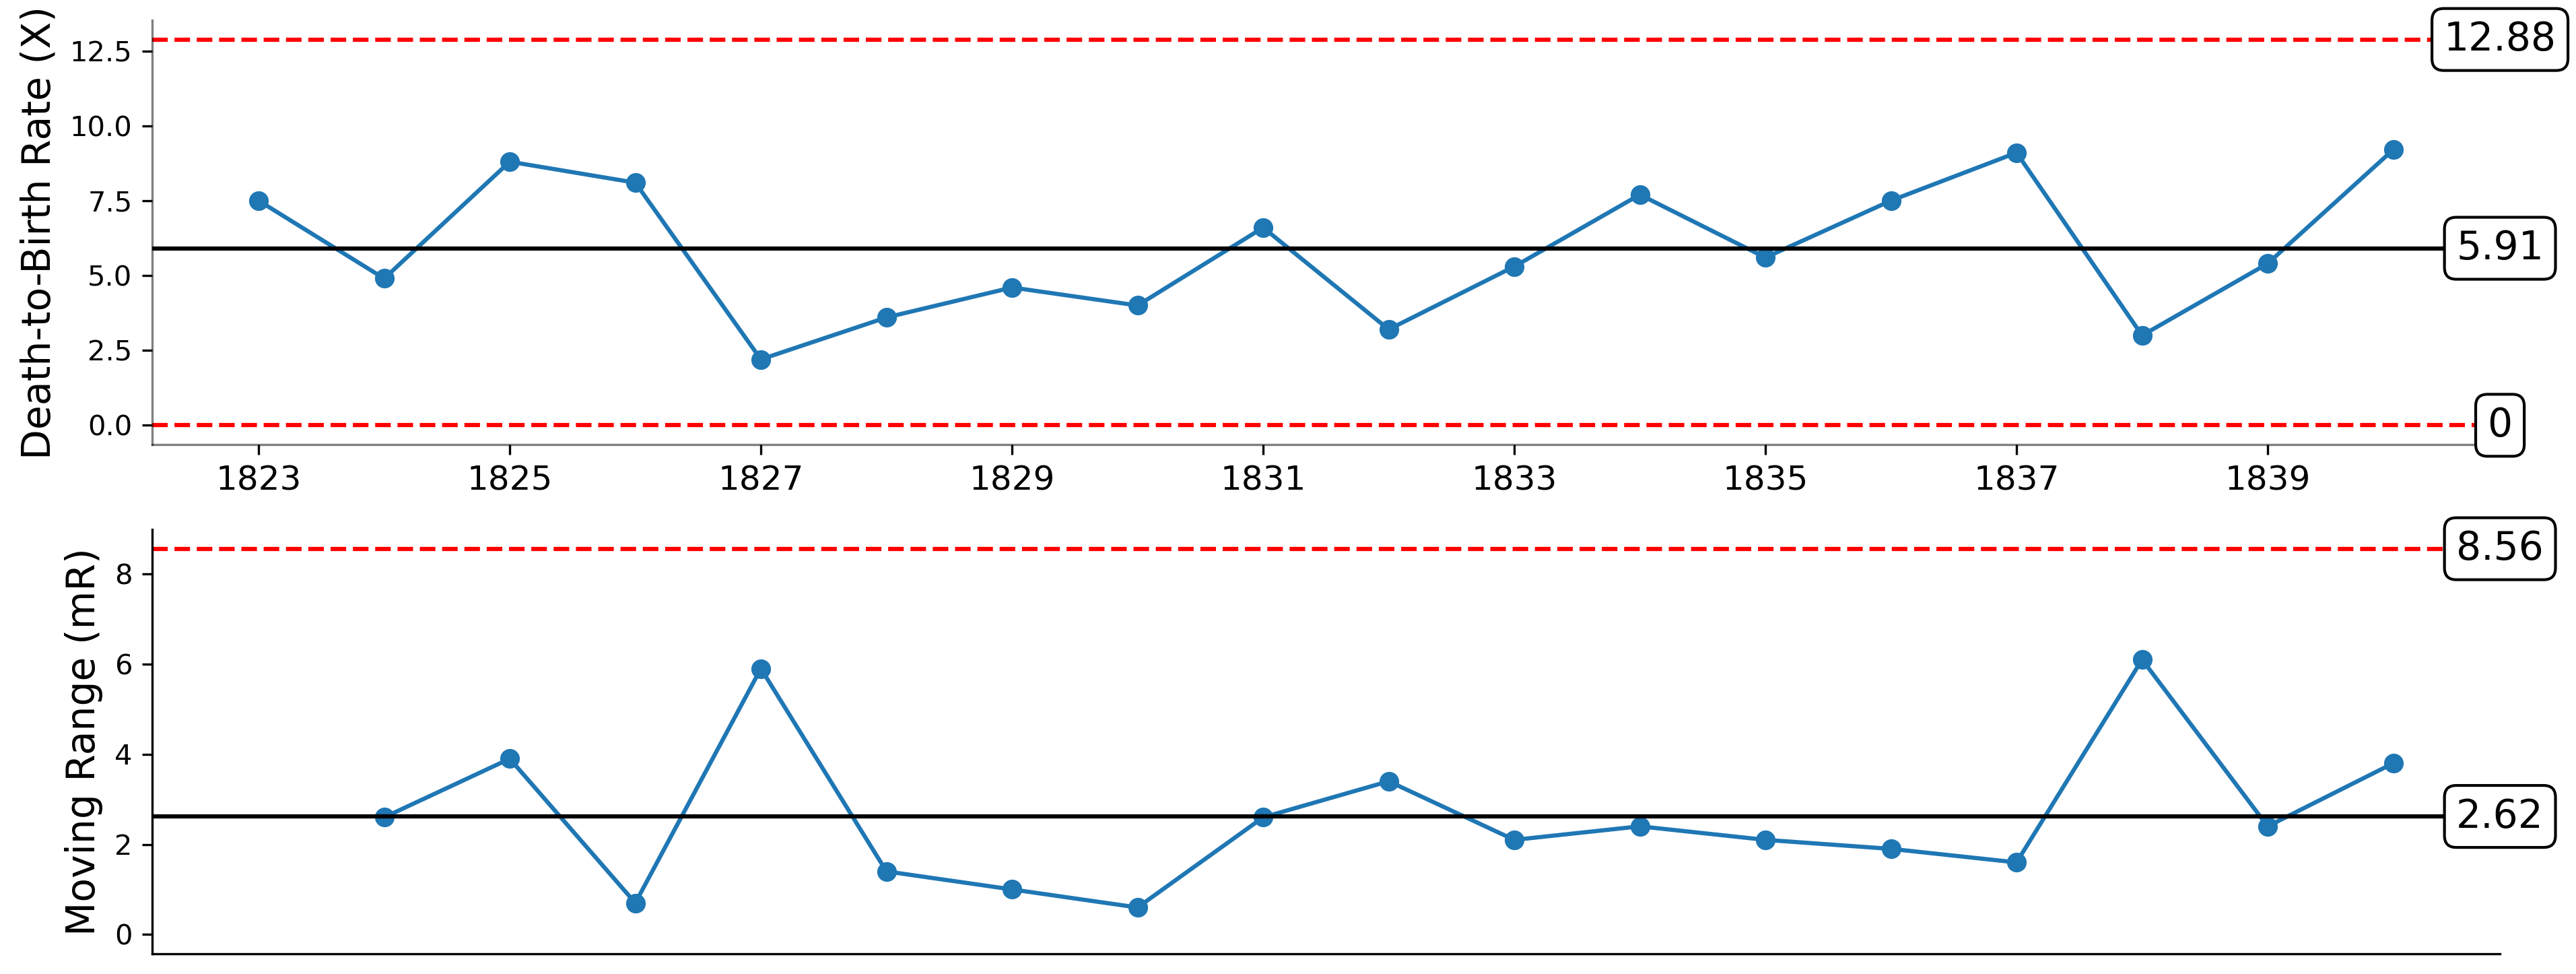

In [123]:
# --- Figure & Axes ---
fig, ax = plt.subplots(2, 1, figsize=(15, 6), dpi=300)

# --- Plot main data ---
ax[0].plot(labels, data, marker='o', label='X data')
ax[1].plot(labels, moving_range, marker='o', label='mR data')

# Create masking parameters for values beyond process limits
masked_values = {
    "upper_lim": np.ma.masked_where(data < after_stats['UPL'], data),
    "lower_lim": np.ma.masked_where(data >  after_stats['LPL'], data),
    "url_greater": np.ma.masked_where(moving_range <= after_stats['URL'], moving_range)
}

# Function to highlight points outside process limits
def highlight_assignable_causes(ax, labels, masked_values, color='tab:red', size=9):
    for key, masked_data in masked_values.items():
        ax.plot(labels, masked_data, marker='o', ls='none', color=color,
                markeredgecolor='black', markersize=size)

# Apply outlier highlighting
highlight_assignable_causes(ax[0], labels, {"upper_lim": masked_values["upper_lim"], "lower_lim": masked_values["lower_lim"]})
highlight_assignable_causes(ax[1], labels, {"url_greater": masked_values["url_greater"]})

# Offset moving ranges by plotting invisible x’s where values are NaN
for xi, yi in zip(labels, moving_range):
    if np.isnan(yi):
        ax[1].plot(xi, 0, marker='x', color='white', markersize=0)

# --- Add process limit & centerline lines ---
for value, linestyle, color in xchart_lines:
    ax[0].axhline(value, ls=linestyle, color=color)
for value, linestyle, color in mrchart_lines:
    ax[1].axhline(value, ls=linestyle, color=color)

# --- Add text labels for limits & centerlines ---
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
for y_val, label in xchart_labels:
    ax[0].text(
        ax[0].get_xlim()[1], y_val, label,
        ha='center', va='center', fontsize=14, bbox=bbox_props
    )
for y_val, label in mrchart_labels:
    ax[1].text(
        ax[1].get_xlim()[1], y_val, label,
        ha='center', va='center', fontsize=14, bbox=bbox_props
    )

# --- Aesthetics ---
sns.despine()
ax[0].spines[['left', 'bottom']].set_alpha(0.5)

# --- X-axis formatting ---
tick_interval = tickinterval
tick_positions = np.arange(0, len(labels), tick_interval)
ax[0].set_xticks(tick_positions)
ax[0].set_xticklabels(labels.iloc[tick_positions], fontsize=12)
ax[1].set_xticks([])  # remove ticks from lower chart

# --- Labels ---
ax[0].set_ylabel("Death-to-Birth Rate (X)", fontsize=14)
ax[1].set_ylabel("Moving Range (mR)", fontsize=14)

# plt.tight_layout()
plt.show()

## Figure CS.3: Comparison of XmR charts before and after pathological anatomy

In [125]:
# Create list of dataframes
df_list = [before_df, after_df]
subplot_titles_list = ['Before pathological anatomy', 
                       'After pathological anatomy']

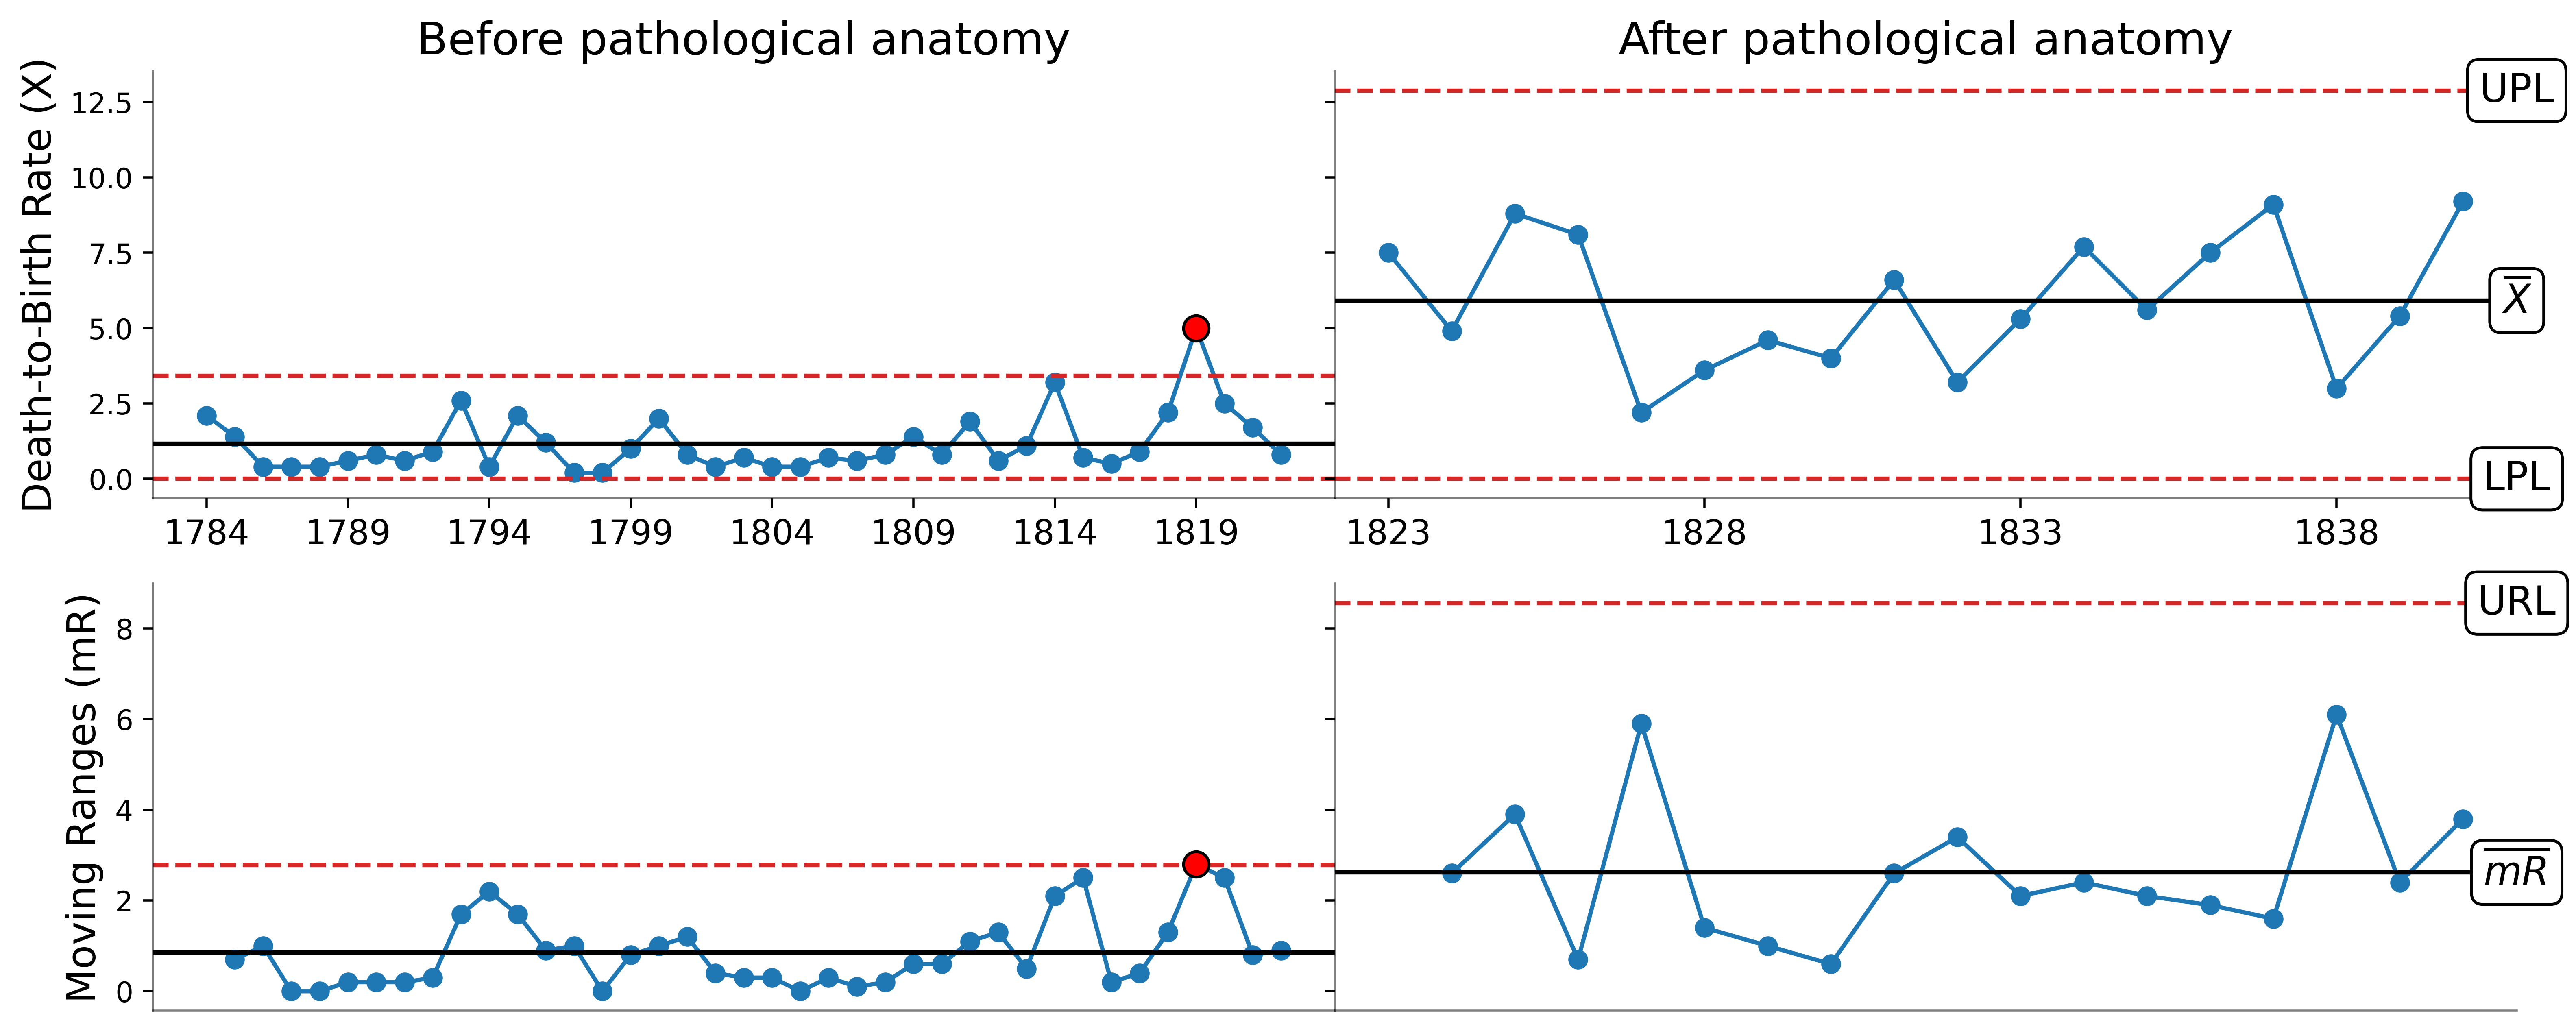

In [135]:
# Specify round_value
round_value = 2
tick_interval = 5
# Specify condition
condition = 'Rate'
labels = 'Year'

# Define plotting parameters
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), dpi=500, sharey='row')
plt.subplots_adjust(wspace=0)

# Initialize an empty list to store stats for each dataframe
stats_list = []

# Loop through the df_list and plot on the axes
for idx, (df, label) in enumerate(zip(df_list, subplot_titles_list)):

    data = df[condition]
    moving_range = round(abs(data.diff()), round_value).copy()
    moving_range.iloc[0] = np.nan
    xticks = df[labels]

    # Specify scaling factors
    E2 = 2.660
    D4 = 3.268

    # Calculate statistics for UPL and LPL
    mean = round(data.mean(), round_value)
    average_mR = round(moving_range.mean(), round_value)
    UPL = round(mean + (E2 * average_mR), round_value)
    LPL = round(max(mean - (E2 * average_mR), 0), round_value)
    URL = round(D4 * average_mR, round_value)

    # Characterize process
    if ((data < LPL) | (data > UPL)).any():
        characterization = "Unpredictable"
    elif (moving_range > URL).any():  # Add condition for moving range exceeding the URL
        characterization = "Unpredictable"
    else:
        characterization = "Predictable"

    # Store statistics in the list
    stats_list.append({
        'Label': label,
        'Mean': mean,
        'Ave. mR': average_mR,
        'UPL': UPL,
        'LPL': LPL,
        'URL': URL,
        'PRL': UPL-LPL,
        'Characterization': characterization
    })

    # Plot individual values in the first two subplots (top row)
    axes[0, idx].plot(data, marker='o')
    # Masking and plotting limits
    axes[0, idx].plot(np.ma.masked_where(data < UPL, data), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)
    axes[0, idx].plot(np.ma.masked_where(data > LPL, data), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)
    axes[0, idx].set_title(label, fontsize=16)

    # Add UPL and LPL horizontal lines for individual values plot
    axes[0, idx].axhline(UPL, color='tab:red', linestyle='--')
    axes[0, idx].axhline(LPL, color='tab:red', linestyle='--')
    axes[0, idx].axhline(mean, color='black', linestyle='-')
    
    # Set x-tick labels with separate intervals
    tick_positions = np.arange(0, len(xticks), tick_interval)
        
    axes[0, idx].set_xticks(tick_positions)
    axes[0, idx].set_xticklabels(xticks.iloc[tick_positions], rotation=0, ha='center', fontsize=12)

    # Plot moving range in the second row
    axes[1, idx].plot(moving_range, marker='o')
    
    # Offset moving range by 1 relative to the individual values
    for xi, yi in zip(labels, moving_range):
        if np.isnan(yi):
            axes[1, idx].plot(xi, 0, marker='x', color='white', markersize=0)

    # Add UPL and LPL horizontal lines for moving range plot
    axes[1, idx].axhline(URL, color='tab:red', linestyle='--')
    axes[1, idx].axhline(average_mR, color='black', linestyle='-')
    axes[1, idx].plot(np.ma.masked_where(moving_range < URL, moving_range), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)

    # Add label to y-axes
    axes[0, 0].set_ylabel('Death-to-Birth Rate (X)', fontsize=14)
    axes[1, 0].set_ylabel('Moving Ranges (mR)', fontsize=14)
    
    # Establish bbox properties
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)

    # Add labels to 2nd and 4th plots
    if idx == 1:
        axes[0, idx].text(axes[0, idx].get_xlim()[1], UPL, 'UPL', color='black', ha='center', va='center',
                          fontsize=14, bbox=bbox_props)
        axes[0, idx].text(axes[0, idx].get_xlim()[1], LPL, 'LPL', color='black', ha='center', va='center', 
                          fontsize=14, bbox=bbox_props)
        axes[0, idx].text(axes[0, idx].get_xlim()[1], mean, r'$\overline{X}$', color='black', ha='center', va='center',
                          fontsize=14, bbox=bbox_props)

    if idx == 1:
        axes[1, idx].text(axes[1, idx].get_xlim()[1], URL, 'URL', color='black', ha='center', va='center', 
                          fontsize=14, bbox=bbox_props)
        axes[1, idx].text(axes[1, idx].get_xlim()[1], average_mR, r'$\overline{mR}$', 
                          color='black', ha='center', va='center', 
                          fontsize=14, bbox=bbox_props)

    # Remove ticks on xticks for moving ranges
    axes[1, idx].set_xticks([])
    
    # Loop through the axes and set spine width
    for ax_row in axes:
        for ax in ax_row:
            for spine in ax.spines.values():
                spine.set_alpha(0.5)

# Stylize plots
sns.despine()
    
# Convert stats list into DataFrame
stats_df = pd.DataFrame(stats_list)